# **Importing**

In [6]:
import pandas as pd
import os
import cv2
import numpy as np
import os
import tensorflow.keras as keras
import random
import numpy as np
import keras
from keras import ops
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# ***Loading & Preprocessing images***  # 

In [7]:
import pandas as pd
import os
import cv2
import numpy as np
import os

train_dir = "/kaggle/input/signature-verification-dataset/sign_data/train"
train_csv = "/kaggle/input/signature-verification-dataset/sign_data/train_data.csv"

# Preprocess function (already defined)
def preprocess_and_combine_fixed(image_path):
    original_image =   cv2.imread(image_path, cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
    if original_image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")
    
    original_image = cv2.resize(original_image, (128, 128), interpolation=cv2.INTER_AREA)
    gray_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (5, 5), 0)
    thresholded_image = cv2.adaptiveThreshold(
        blurred_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 15, 7
    )
    inverted_image = cv2.bitwise_not(thresholded_image)
    kernel = np.ones((2, 2), np.uint8)
    cleaned_image = cv2.morphologyEx(inverted_image, cv2.MORPH_OPEN, kernel)
    preprocessed_image = cleaned_image.astype("float32") / 255.0
    return preprocessed_image

train_data = pd.read_csv(train_csv, header=None, names=["image1", "image2", "label"])

# Preprocess all image pairs
preprocessed_data = []
labels = []

for idx, row in train_data.iterrows():
    img1_path = os.path.join(train_dir, row["image1"])
    img2_path = os.path.join(train_dir, row["image2"])
    
    try:
        img1 = preprocess_and_combine_fixed(img1_path)
        img2 = preprocess_and_combine_fixed(img2_path)
        preprocessed_data.append((img1, img2))
        labels.append(row["label"])
    except FileNotFoundError as e:
        print(e)

preprocessed_data = np.array(preprocessed_data)
labels = np.array(labels, dtype="float32")

print(f"Preprocessed data shape: {preprocessed_data.shape}")
print(f"Labels shape: {labels.shape}")


libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Preprocessed data shape: (23206, 2, 128, 128)
Labels shape: (23206,)


# **Eculedian Destance**

In [9]:
def euclidean_distance(vects):
 
    x, y = vects
    sum_square = ops.sum(ops.square(x - y), axis=1, keepdims=True)
    return ops.sqrt(ops.maximum(sum_square, keras.backend.epsilon()))

# **Siamese Model**

In [10]:
input = keras.layers.Input((128, 128, 1))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(16, (3, 3), activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(16, (3, 3), activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Conv2D(28, (3, 3), activation="relu")(x)
x = keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = keras.layers.Flatten()(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(28, activation="tanh")(x)
embedding_network = keras.Model(input, x)

input_1 = keras.layers.Input((128, 128, 1))
input_2 = keras.layers.Input((128, 128, 1))

 
tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))(
    [tower_1, tower_2]
)
normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)
siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

siamese.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_5        │ (None, 28)        │    182,188 │ input_layer_4[0]… │
│ (Functional)        │                   │            │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 1)         │          0 │ functional_5[0][… │
│                     │                   │            │ functional_5[1][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 182,194 (711.70 KB)

 Trainable params: 171,214 (668.80 KB)

 Non-trainable params: 10,980 (42.89 KB)

# **Spliting and Prepare the data**

In [11]:
x_train, x_val, labels_train, labels_val = train_test_split(
    preprocessed_data, labels, test_size=0.2, random_state=42, stratify=labels
)
x_train_1 = x_train[:, 0].reshape(-1, 128, 128, 1)
x_train_2 = x_train[:, 1].reshape(-1, 128, 128, 1)

x_val_1 = x_val[:, 0].reshape(-1, 128, 128, 1)
x_val_2 = x_val[:, 1].reshape(-1, 128, 128, 1)


batch_size = 64
epochs = 20
# Compile Siamese 
siamese.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

# Train
history = siamese.fit(
    [x_train_1, x_train_2],
    labels_train,
    validation_data=([x_val_1, x_val_2], labels_val),
    batch_size=batch_size,
    epochs=epochs
)

# Print model summary
print("Model training completed.")

Epoch 1/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7392 - loss: 0.5346

I0000 00:00:1734184734.345894      92 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_4', 72 bytes spill stores, 72 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_select_fusion_5', 72 bytes spill stores, 72 bytes spill loads



291/291 ━━━━━━━━━━━━━━━━━━━━ 14s 33ms/step - accuracy: 0.7395 - loss: 0.5343 - val_accuracy: 0.9330 - val_loss: 0.2728
Epoch 2/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9619 - loss: 0.2533 - val_accuracy: 0.9884 - val_loss: 0.1899
Epoch 3/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9941 - loss: 0.1950 - val_accuracy: 0.9968 - val_loss: 0.1551
Epoch 4/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - accuracy: 0.9994 - loss: 0.1655 - val_accuracy: 0.9991 - val_loss: 0.1366
Epoch 5/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.9995 - loss: 0.1525 - val_accuracy: 1.0000 - val_loss: 0.1206
Epoch 6/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9994 - loss: 0.1401 - val_accuracy: 1.0000 - val_loss: 0.1084
Epoch 7/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9992 - loss: 0.1299 - val_accuracy: 1.0000 - val_loss: 0.0998
Epoch 8/20
291/291 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - accuracy: 0.9995 - loss: 0.1193 - val_accuracy: 1.00

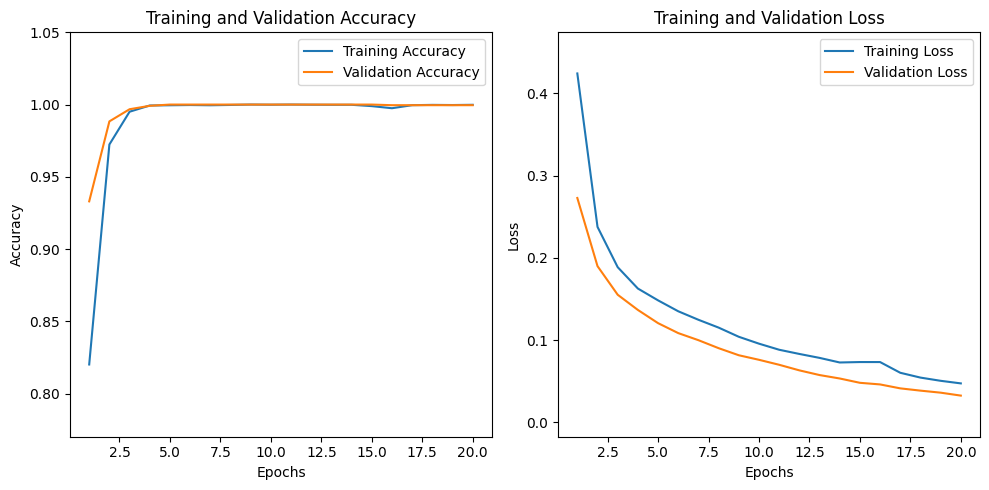

In [12]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, epochs + 1)

# Accuracy plotting
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1) 
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim([min(min(acc), min(val_acc)) - 0.05, max(max(acc), max(val_acc)) + 0.05])

# loss plotting
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.ylim([min(min(loss), min(val_loss)) - 0.05, max(max(loss), max(val_loss)) + 0.05]) 

plt.tight_layout()
plt.show()


In [15]:
def visualize_preprocessed_pairs(preprocessed_data, labels, num_pairs=20):
    #select random image pairs
    random_indices = np.random.choice(len(preprocessed_data), num_pairs, replace=False)  
    plt.figure(figsize=(10, num_pairs * 2)) 
    for i, idx in enumerate(random_indices):
        img1, img2 = preprocessed_data[idx]
        label = labels[idx]
        
        plt.subplot(num_pairs, 2, 2 * i + 1)
        plt.imshow(img1, cmap='gray')
        plt.title("Image 1")
        plt.axis("off")
        
        plt.subplot(num_pairs, 2, 2 * i + 2)
        plt.imshow(img2, cmap='gray')
        plt.title(f"Image 2\nLabel: {'Match' if label == 0 else 'Mismatch'}")
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

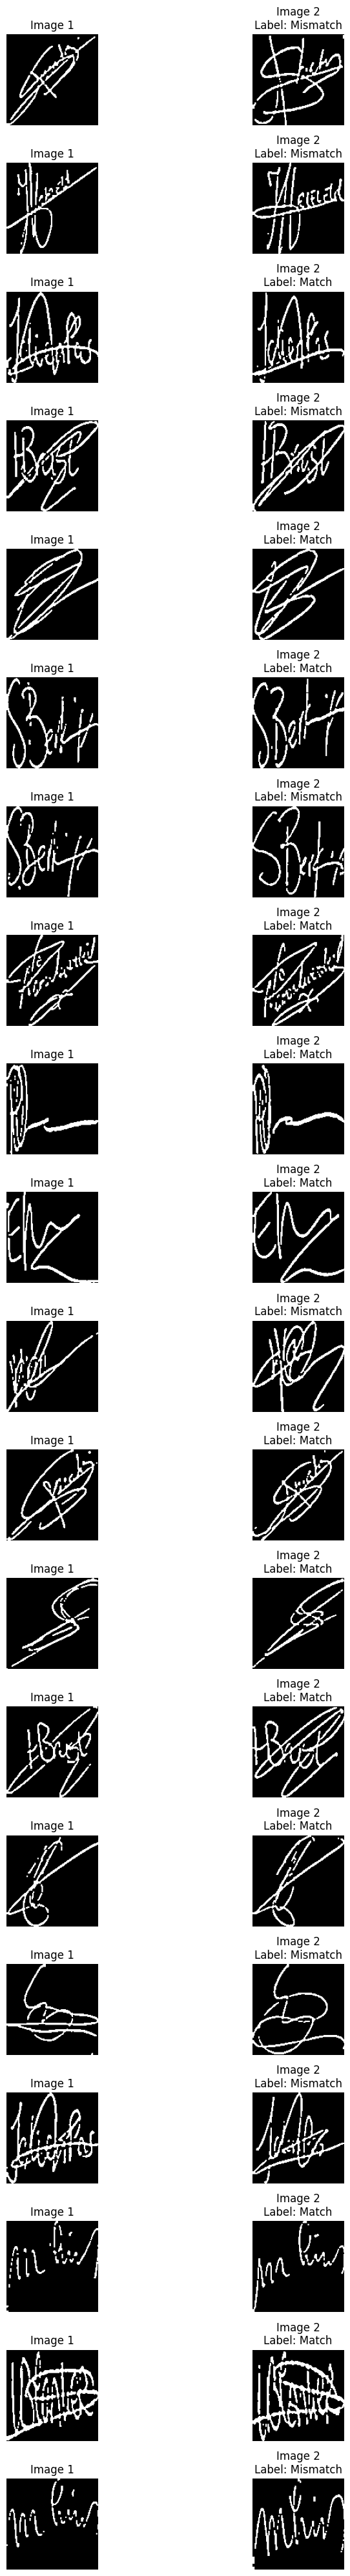

In [16]:
visualize_preprocessed_pairs(preprocessed_data, labels, num_pairs=20)

# **Evaluate in first test data set**

In [20]:
test_dir = "/kaggle/input/signature-verification-dataset/sign_data/test"
test_csv = "/kaggle/input/signature-verification-dataset/sign_data/test_data.csv"
test_data = pd.read_csv(test_csv, header=None, names=["image1", "image2", "label"])

In [21]:
# Preprocess test pairs
preprocessed_test_data = []
test_labels = []

for idx, row in test_data.iterrows():
    img1_path = os.path.join(test_dir, row["image1"])
    img2_path = os.path.join(test_dir, row["image2"])
    
    try:
        img1 = preprocess_and_combine_fixed(img1_path)
        img2 = preprocess_and_combine_fixed(img2_path)
        preprocessed_test_data.append((img1, img2))
        test_labels.append(row["label"])
    except FileNotFoundError as e:
        print(e)
preprocessed_test_data = np.array(preprocessed_test_data)
test_labels = np.array(test_labels, dtype="float32")

print(f"Preprocessed test data shape: {preprocessed_test_data.shape}")
print(f"Test labels shape: {test_labels.shape}")

x_test_1 = preprocessed_test_data[:, 0].reshape(-1, 128, 128, 1)
x_test_2 = preprocessed_test_data[:, 1].reshape(-1, 128, 128, 1)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known inc

Preprocessed test data shape: (5748, 2, 128, 128)
Test labels shape: (5748,)


In [22]:
test_loss, test_accuracy = siamese.evaluate([x_test_1, x_test_2], test_labels, batch_size=batch_size)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9998 - loss: 0.0317
Test Loss: 0.03327403590083122
Test Accuracy: 0.9993041157722473


90/90 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


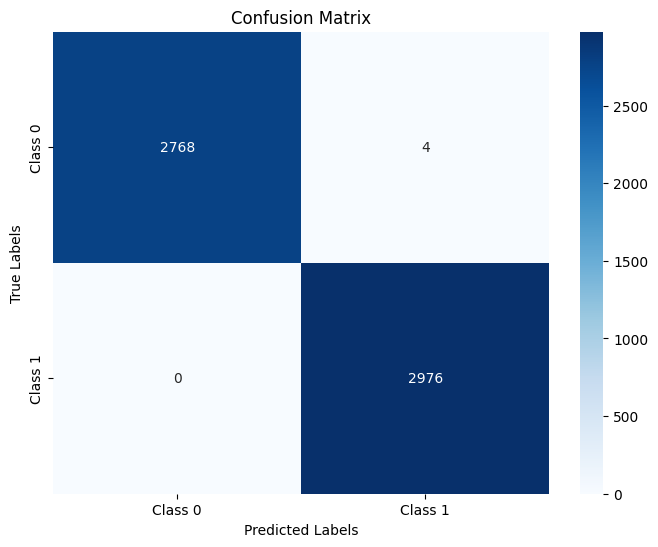

In [23]:
from sklearn.metrics import confusion_matrix

y_test_pred = siamese.predict([x_test_1, x_test_2], batch_size=batch_size)
y_test_pred_classes = np.where(y_test_pred > 0.5, 1, 0)

# Generate confusion matrix
cm = confusion_matrix(test_labels, y_test_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [25]:
from sklearn.metrics import f1_score
#F1-Score
f1 = f1_score(test_labels, y_test_pred_classes, average='weighted')
print(f"F1-Score is: {f1:.4f}")

F1-Score is: 0.9993


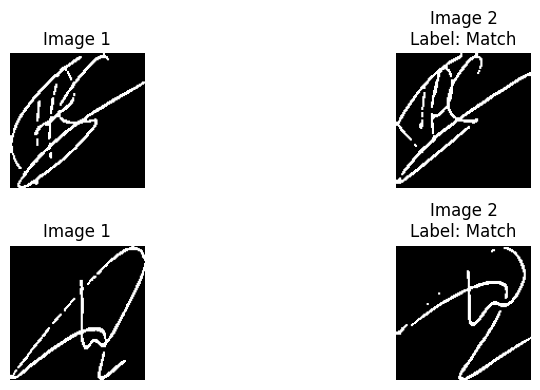

In [26]:
visualize_preprocessed_pairs(preprocessed_test_data, test_labels, num_pairs=2)

# **test for second dataset**

In [34]:
test_dataset = pd.read_csv('/kaggle/input/signature-verification-dataset-iraninan-csv/signature-verification-dataset-iraninan.csv', header=None, skiprows=2)
test_dir = "/kaggle/input/signature-verification-dataset-iraninan/test"


def load_image(image_path, target_size=(128, 128)):
    try:
        full_path = os.path.join(test_dir, image_path)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Image not found: {full_path}")
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to read image: {full_path}")
        return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

In [45]:
def evaluate_siamese_model_with_metrics(dataset, model):
    X1 = []
    X2 = []
    y_true = [] 
    for i in range(len(dataset)):
        row = dataset.iloc[i]
        img1 = load_image(row[0])
        img2 = load_image(row[1])
        if img1 is None or img2 is None:
            print(f"Skipping invalid pair: {row[0]}, {row[1]}")
            continue
        X1.append(img1)
        X2.append(img2)
        y_true.append(row[2])   
    X1 = np.array(X1, dtype=np.float32)
    X2 = np.array(X2, dtype=np.float32)
    y_true = np.array(y_true, dtype=np.float32)

    X1 = np.expand_dims(X1, axis=-1)
    X2 = np.expand_dims(X2, axis=-1)

    # Evaluate the model
    loss, accuracy = model.evaluate([X1, X2], y_true, verbose=1)
    print(f"Test Loss: {loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")

    y_pred = model.predict([X1, X2], verbose=1)
    y_pred_classes = np.where(y_pred > 0.5, 1, 0)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred_classes)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # F1-Score
    f1 = f1_score(y_true, y_pred_classes, average='weighted')
    print(f"F1-Score: {f1:.4f}")


150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7278 - loss: 1.1706
Test Loss: 1.2579
Test Accuracy: 0.6794
150/150 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


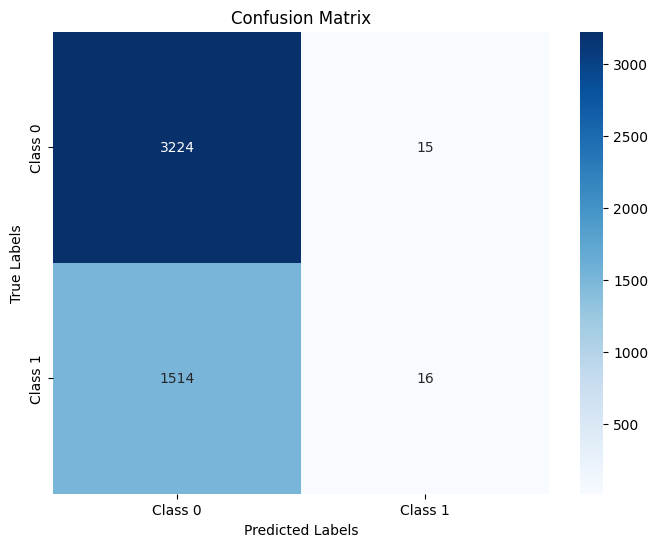

F1-Score: 0.5556


In [46]:
evaluate_siamese_model_with_metrics(test_dataset, siamese)

# **Test third Data set**

In [76]:
 test_dataset = pd.read_csv('/kaggle/input/signature-forgery-dataset-test-csv/signature-forgery-dataset_test.csv', header=None, skiprows=2)
test_dir = "/kaggle/input/signature-forgery-dataset/Test"


def load_image_num3(image_path, target_size=(128, 128)):
    try:
        full_path = os.path.join(test_dir_num3, image_path)
        if not os.path.exists(full_path):
            raise FileNotFoundError(f"Image not found: {full_path}")
        image = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise ValueError(f"Failed to read image: {full_path}")
        return cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
    except Exception as e:
        print(f"Error loading image: {e}")
        return None

In [78]:
def evaluate_siamese_model3(dataset3, model3):
    X13 = []
    X23 = []
    y3 = []
    
    for i3 in range(len(dataset3)): 
        row3 = dataset3.iloc[i3]
        img13 = load_image3(row3[0])
        img23 = load_image3(row3[1])
        if img13 is None or img23 is None:
            print(f"Skipping invalid pair: {row3[0]}, {row3[1]}")
            continue
        X13.append(img13)
        X23.append(img23)
        y3.append(row3[2])


    X13 = np.array(X13, dtype=np.float32)
    X23 = np.array(X23, dtype=np.float32)
    y3 = np.array(y3, dtype=np.float32)

    X13 = np.expand_dims(X13, axis=-1)
    X23 = np.expand_dims(X23, axis=-1)
    loss3, accuracy3 = model3.evaluate([X13, X23], y3, verbose=1)
    print(f"Test Loss: {loss3:.4f}")
    print(f"Test Accuracy: {accuracy3:.4f}")

    # Predict the outputs
    y_pred3 = model3.predict([X13, X23])
    y_pred3 = np.round(y_pred3).astype(int)

    # Calculate confusion matrix and F1 score
    cm3 = confusion_matrix(y3, y_pred3)
    f1_3 = f1_score(y3, y_pred3)



In [79]:
evaluate_siamese_model3(test_dataset3, siamese)

242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7298 - loss: 1.1874
Test Loss: 1.3885
Test Accuracy: 0.6720
242/242 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
